# Generative Adversarial Network

Reference: https://github.com/eriklindernoren/Keras-GAN/

## Setting

Mount Google Drive

In [1]:
from google.colab import drive

mount_folder = '/content/gdrive'
drive.mount(mount_folder)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Go into the working directory

In [0]:
import os

app_folder = mount_folder + '/My Drive/'
os.chdir(app_folder)

Input

In [0]:
from pathlib import Path

def get_banner_folder(prefixe = 'original'):
  banner_folder = 'data/'+prefixe+'_steam_banners/'
  Path(banner_folder).mkdir(exist_ok=True)  
  return banner_folder

def get_file_extension():
  return '.jpg'
  
def get_banner_file_name(app_id):
  return get_banner_folder() + str(app_id) + get_file_extension()

Banners which are a black background

In [0]:
def get_skipped_banners():
  skipped_app_ids = [396540]
  skipped_banners = [get_banner_folder() + str(app_id) + get_file_extension() for app_id in skipped_app_ids]
  return skipped_banners

## Aggregate 56x56 images once, for faster processing later on

Aggregate Steam banners into a NumPy structure

---



In [5]:
import glob
import numpy as np

from time import time

from keras.preprocessing.image import load_img

def get_matrix_file_name(img_rows=56, img_cols=56, channels=1):
  return 'data/banner_matrix_'+str(img_rows)+'x'+str(img_cols)+'x'+str(channels)+'.npy'


def prepare_data_matrix(img_rows=56, img_cols=56, channels=1, prefixe = 'original', reset_matrix=False):     
  all_image_names = glob.glob(get_banner_folder(prefixe) + '*' + get_file_extension())  
  
  # There is an issue with duplicates, e.g. 'ABC (1).jpg' but only when running on Google Drive:
  image_names = [img for img in all_image_names if ' (' not in img]
  
  num_samples = len(image_names)
    
  if reset_matrix:
    X_train = np.zeros((num_samples, img_rows, img_cols, channels))    
  else:
    try:
      X_train = np.load(get_matrix_file_name(img_rows, img_cols, channels))
    except FileNotFoundError:
      X_train = np.zeros((num_samples, img_rows, img_cols, channels))    
    
  has_changed = False
  start = time()
  
  for counter, image_name in enumerate(sorted(image_names)):    
    
    if np.any(X_train[counter,...]!=0) or (image_name in get_skipped_banners()):
      continue
    
    if (counter+1) % 100 == 0:
      print('Elapsed time: {:.2f} s'.format(time() - start))
      start = time()      
      print('Iteration {}/{}'.format(counter+1, num_samples))
      if has_changed:
        np.save(get_matrix_file_name(img_rows, img_cols, channels), X_train)
        has_changed = False        

    image = load_img(image_name, target_size=(img_rows, img_cols))    
    has_changed = True
    
    # Grayscale
    if channels==1:
      image = np.expand_dims(np.mean(image, axis=2), axis=2)

    X_train[counter, ...] = image    
  
  if has_changed:
    print('Saving.')
    np.save(get_matrix_file_name(img_rows, img_cols, channels), X_train)
  
  return X_train

Using TensorFlow backend.


Choose image size and the number of channels (color vs. grayscale image). Preferably, choose a rather high image size, e.g. 56x56, so that the NumPy structure has a decent size but is not too large, e.g. about 2 GB if images have 3 color channels.

If we need smaller images later on, we could load this dataset and downsample the stored images. The fact that we would not have to load the images from the disk would make the process fast enough.

In [0]:
default_img_rows=56
default_img_cols=56
default_channels=3

Aggregate images, resized to 56x56 pixels

In [0]:
X_train = prepare_data_matrix(img_rows=default_img_rows, img_cols=default_img_cols, channels=default_channels, prefixe='resized', reset_matrix=False)  

## Pre-processing

Choose image size and the number of channels (color vs. grayscale image)

In [0]:
img_rows=28
img_cols=28
channels=3

# Color images cannot be created from stored grayscale images
assert(channels <= default_channels)

Resize images stored in X_train

In [0]:
import cv2

input_file_name = get_matrix_file_name(default_img_rows, default_img_cols, default_channels)
output_file_name = get_matrix_file_name(img_rows, img_cols, channels)

if not Path(output_file_name).exists():

  X_train = np.load(input_file_name)

  num_samples = X_train.shape[0]

  X_train_resized = np.zeros((num_samples, img_rows, img_cols, channels))
  for index, image in enumerate(X_train):
    resized_image = cv2.resize(image, (img_rows, img_cols))

    if default_channels > 1:
      if channels > 1:
        pass
      else:
        resized_image = np.mean(resized_image, axis=2)
        resized_image = np.expand_dims(resized_image, axis=2)
    else:
      resized_image = np.expand_dims(resized_image, axis=2)

    X_train_resized[index, ...] = resized_image

  np.save(output_file_name, X_train_resized)

Load pre-computed aggregate of resized Steam banners

In [10]:
X_train = np.load(get_matrix_file_name(img_rows, img_cols, channels))

X_train.shape

(27974, 28, 28, 3)

Display Steam banners of real games

In [0]:
import matplotlib.pyplot as plt
import cv2

def plot_grid_of_banners(banner_matrix, r=5, c=3, upsample_to_original_size=True):
  
  if upsample_to_original_size:
    original_shape = [215, 460]
    num_banners_to_print = r*c
    
    gen_imgs_large = np.zeros((num_banners_to_print, original_shape[0], original_shape[1], banner_matrix.shape[-1]))
    for i in range(num_banners_to_print):
      gen_imgs_large[i, ...] = cv2.resize(banner_matrix[i, ...], (original_shape[1], original_shape[0]))
      
    banner_matrix = gen_imgs_large.copy()
  
  num_channels = banner_matrix.shape[-1]

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          if num_channels > 1:
            image = np.array(banner_matrix[cnt, ...])
          else:
            image = 255 - np.array(banner_matrix[cnt, :, :, 0])
          # Reference: https://stackoverflow.com/a/51255361
          axs[i,j].imshow(image.astype(np.uint8))
          axs[i,j].axis('off')
          cnt += 1
  plt.show()          
  
  return

def plot_samples_generated_by_model(model, r=5, c=3, upsample_to_original_size=True): 
  
  noise = np.random.normal(0, 1, (r * c, model.latent_dim))
  gen_imgs = model.generator.predict(noise)
 
  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  # Rescale images 0 - 255
  gen_imgs = 255 * gen_imgs
    
  plot_grid_of_banners(gen_imgs, r, c, upsample_to_original_size)
  
  return

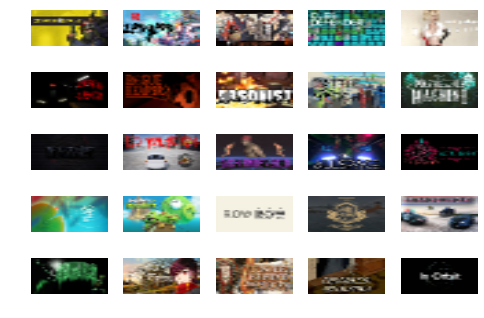

In [28]:
plot_grid_of_banners(X_train)

## Train GAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class GAN():
    # CODE CHANGED BELOW
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_gan/'
        Path(self.image_folder).mkdir(exist_ok=True)             
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
              # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])                    
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [15]:
gan = GAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable para

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [17]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

gan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 5464 with mini-batch size = 128 for 25 epochs over 27974 samples
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.712042, acc.: 33.98%] [G loss: 0.515880]
100 [D loss: 0.754313, acc.: 60.16%] [G loss: 1.276081]
200 [D loss: 0.798369, acc.: 52.73%] [G loss: 1.111127]
300 [D loss: 0.731146, acc.: 58.59%] [G loss: 1.023637]
400 [D loss: 0.788774, acc.: 44.92%] [G loss: 0.894888]
500 [D loss: 0.781819, acc.: 36.33%] [G loss: 0.822662]
600 [D loss: 0.790069, acc.: 24.22%] [G loss: 0.820587]
700 [D loss: 0.712545, acc.: 50.78%] [G loss: 0.805980]
800 [D loss: 0.726856, acc.: 48.44%] [G loss: 0.784095]
900 [D loss: 0.729395, acc.: 47.27%] [G loss: 0.805397]
1000 [D loss: 0.727005, acc.: 46.48%] [G loss: 0.755089]
1100 [D loss: 0.731260, acc.: 34.77%] [G loss: 0.778040]
1200 [D loss: 0.723763, acc.: 42.58%] [G loss: 0.740025]
1300 [D loss: 0.722160, acc.: 42.58%] [G loss: 0.754269]
1400 [D loss: 0.738831, acc.: 29.30%] [G loss: 0.739615]
1500 [D loss: 0.722224, acc.: 47.66%] [G loss: 0.730419]
1600 [D loss: 0.701361, acc.: 47.66%] [G loss: 0.743172]
1700 [D loss: 0.715662, acc.: 39.45%] [G lo

Display sampled banners

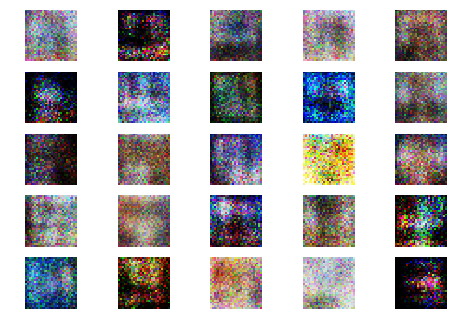

In [18]:
plot_samples_generated_by_model(gan)

## Train WGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class WGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_wgan/'
        Path(self.image_folder).mkdir(exist_ok=True)                
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Flatten())
          model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Reshape(self.img_shape))      

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:        
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)
                
                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [21]:
wgan = WGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        448       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 32)          128       
___________________________

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [23]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

wgan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Number of iterations = 5464 with mini-batch size = 128 for 25 epochs over 27974 samples


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999926] [G loss: 1.000145]
100 [D loss: 0.999978] [G loss: 1.000077]
200 [D loss: 0.999970] [G loss: 1.000068]
300 [D loss: 0.999970] [G loss: 1.000067]
400 [D loss: 0.999972] [G loss: 1.000066]
500 [D loss: 0.999971] [G loss: 1.000070]
600 [D loss: 0.999974] [G loss: 1.000061]
700 [D loss: 0.999974] [G loss: 1.000051]
800 [D loss: 0.999974] [G loss: 1.000060]
900 [D loss: 0.999975] [G loss: 1.000064]
1000 [D loss: 0.999974] [G loss: 1.000064]
1100 [D loss: 0.999974] [G loss: 1.000061]
1200 [D loss: 0.999973] [G loss: 1.000059]
1300 [D loss: 0.999976] [G loss: 1.000057]
1400 [D loss: 0.999975] [G loss: 1.000058]
1500 [D loss: 0.999976] [G loss: 1.000049]
1600 [D loss: 0.999978] [G loss: 1.000048]
1700 [D loss: 0.999970] [G loss: 1.000054]
1800 [D loss: 0.999977] [G loss: 1.000061]
1900 [D loss: 0.999973] [G loss: 1.000052]
2000 [D loss: 0.999979] [G loss: 1.000053]
2100 [D loss: 0.999989] [G loss: 1.000024]
2200 [D loss: 0.999971] [G loss: 1.000063]
2300 [D loss: 0.999974]

Display sampled banners

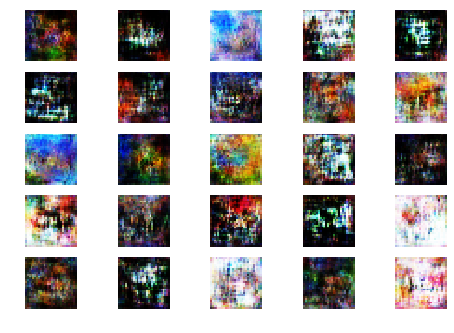

In [24]:
plot_samples_generated_by_model(wgan)

## Train DCGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class DCGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_dcgan/'
        Path(self.image_folder).mkdir(exist_ok=True)                
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Flatten())
          model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        # CODE CHANGED BELOW  
        if self.img_shape[0] != 28 or self.img_shape[1] != 28:
          model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [55]:
dcgan = DCGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

dcgan.train(epochs=num_iter, batch_size=batch_size, save_interval=1000)

Display sampled banners

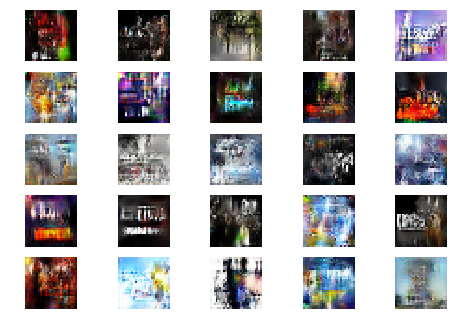

In [58]:
plot_samples_generated_by_model(dcgan)

## Train BGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/bgan/bgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class BGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/"""
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_bgan/'
        Path(self.image_folder).mkdir(exist_ok=True)            

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.boundary_loss, optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def boundary_loss(self, y_true, y_pred):
        """
        Boundary seeking loss.
        Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
        """
        return 0.5 * K.mean((K.log(y_pred) - K.log(1 - y_pred))**2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name(self.img_rows, self.img_cols, self.channels))
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)      

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            # CODE CHANGED BELOW
            if epoch % 100 == 0:            
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                 # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [44]:
bgan = BGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable params: 0
_________________________________________________________________


Training parameters

In [0]:
num_epochs = 250
batch_size = 128

In [0]:
num_samples = X_train.shape[0]
num_iter = int(num_epochs * num_samples / batch_size) + 1
print('Number of iterations = {} with mini-batch size = {} for {} epochs over {} samples'.format(num_iter, batch_size, num_epochs, num_samples))

bgan.train(epochs=num_iter, batch_size=batch_size, sample_interval=1000)

Display sampled banners

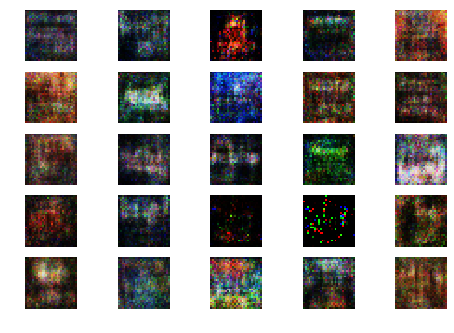

In [52]:
plot_samples_generated_by_model(bgan)

## Save models to disk

In [0]:
import pickle

pickle.save

